# Classification

### Import Packages

In [1]:
!pip install bayesian-optimization

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import itertools
import gensim

import nltk
from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC  
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from bayes_opt import BayesianOptimization
from tqdm import tqdm
tqdm.pandas(desc="progress-bar") 
from gensim.models.doc2vec import TaggedDocument

from xgboost import XGBClassifier

p_stemmer = PorterStemmer() # initialize PorterStemmer

# Set seed for RNG
SEED = 12

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xiaoy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xiaoy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\xiaoy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\xiaoy\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Fetching from Github

After further manual data-preprocessing, raw dataset is uploaded to Github and retrieved via url link.

In [2]:
# Retrieve dataset via url link
# Github Repo: https://github.com/X-Yang98/CE4045-NLP
overall_url = "https://raw.githubusercontent.com/xiao-yangg/CE4045-NLP/main/combined_dataset.csv"

overall_df = pd.read_csv(overall_url, encoding='latin') # train and test dataset

In [3]:
# Sanity check for any duplicates
overall_df.drop_duplicates(['tweet'], inplace=True)

# Add index column for identification
overall_df['index'] = list(overall_df.index)

Inter-annotator agreement for evaluation dataset.

In [4]:
no_disagreements = len(overall_df[((overall_df['label_1'] != overall_df['label_2']) | 
                                (overall_df['label_2'] != overall_df['label_3']) |
                                (overall_df['label_3'] != overall_df['label_1'])
                               )])

print("Inter-annotator agreement is {}%.".format((len(overall_df) - no_disagreements)/len(overall_df)*100))

Inter-annotator agreement is 89.29166666666667%.


General function to display sentiment and sentence length distribution.

In [5]:
def show_distribution(label, tweets, name):
    plt.figure(figsize=(18,6))

    # Bar graph visualisation of sentiment distribution
    plt.subplot(1,2,1)
    sns.countplot(x=label)
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.title("Sentiments Distribution in " + name + " Dataset")

    # Bar graph visualisation of sentence length distribution
    plt.subplot(1,2,2)
    sns.histplot([len(s) for s in tweets], bins=100)
    plt.xlabel("Sentence Length")
    plt.ylabel("Count")
    plt.title("Sentence Length Distribution in " + name + " Dataset")

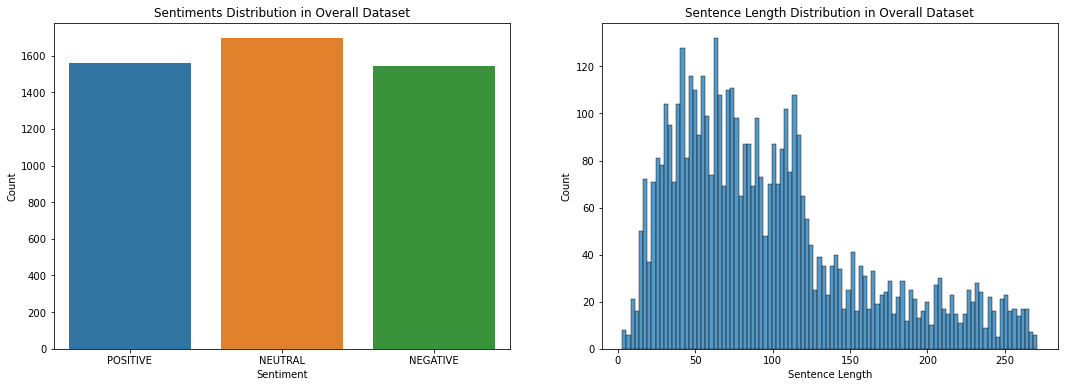

In [6]:
show_distribution(overall_df['final_label'], overall_df['tweet'], "Overall")

### Text Normalization


In [7]:
# Tokenization
def tokenize(text):
    return word_tokenize(text)

# Removal of Stopwords
def remove_stopword(text):
    nltk_tokenList = tokenize(text) # tokenize

    filtered_sentence = [] # sentence without stopwords
    nltk_stop_words = set(stopwords.words("english"))
    for w in nltk_tokenList:  
        if w not in nltk_stop_words:  
            filtered_sentence.append(w)
    
    return ' '.join(filtered_sentence)

# Stemming
def stemming(token_list):
    stemmed_list = []
    for word in token_list:
        stemmed_list.append(p_stemmer.stem(word))

    return stemmed_list

# Lemmatization
def lemmatization(stemmed_list):
    wordnet_lemmatizer = WordNetLemmatizer()
    lemma_list = []
    for word in stemmed_list:
        lemma_list.append(wordnet_lemmatizer.lemmatize(word))

    return lemma_list

# Combination of stemming and lemmatization
def nltk_process(text):
    nltk_tokenList = tokenize(text) # tokenize
    nltk_stemmedList = stemming(nltk_tokenList) # stemmed
    nltk_lemmaList = lemmatization(nltk_stemmedList) # lemma

    return ' '.join(nltk_tokenList)

Apply normalization to dataset.

In [8]:
def normalize_df(df):    
    df['no_stopword_tweet'] = df['tweet'].apply(remove_stopword) # obtain tweet without stopwords
    df['normalize_tweet'] = df['no_stopword_tweet'].apply(nltk_process) # tweet with no stopwords go through stemming and lemma

    # New dataframe of text normalized tweets
    columns_titles = ['normalize_tweet','final_label', 'index']
    return df.reindex(columns=columns_titles)

In [9]:
norm_df = normalize_df(overall_df)

### Split into train and test datasets

In [10]:
X_train, X_test, y_train, y_test = train_test_split(norm_df['normalize_tweet'], # tweet
                                                    norm_df[['final_label', 'index']], # label, index
                                                    test_size=0.25, # test size 25% 
                                                    random_state = SEED,
                                                    shuffle=True,
                                                    stratify=norm_df['final_label']) # ensure even proportion of Positive, Negative, Neutral in test data

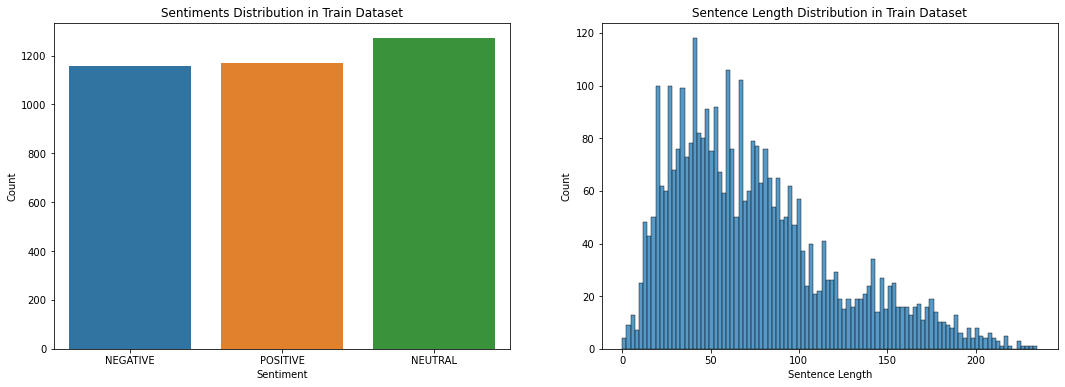

In [11]:
show_distribution(y_train['final_label'], X_train, "Train")

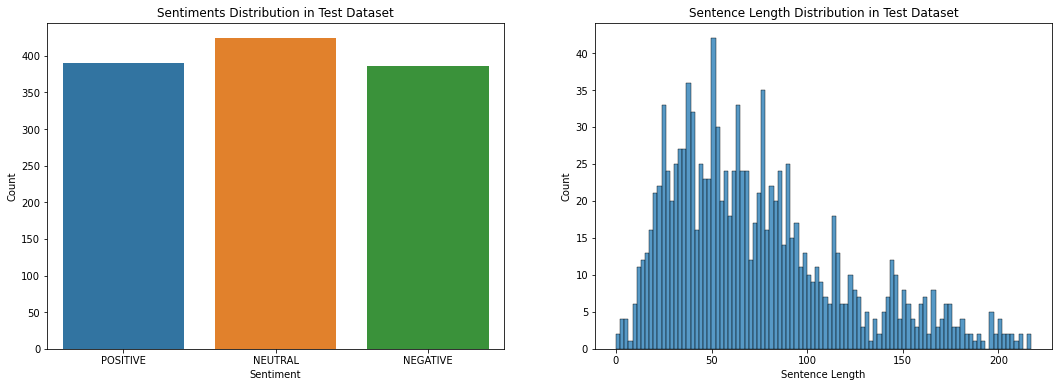

In [12]:
show_distribution(y_test['final_label'], X_test, "Test")

### Model Helpers

#### Logs

Storing results for comparision.

In [13]:
logs = {'models': {}, 'metrics': {}}
logs['models']['X_test'] = list(X_test)
logs['models']['y_test'] = list(y_test['final_label'])
logs['models']['index'] = list(y_test['index'])

# Remove index since we already stored
y_train = y_train['final_label']
y_test = y_test['final_label']

#### Vectorizers

Bag of Words (CountVectorizer)

In [14]:
count_vec = CountVectorizer(max_features=2000, min_df=5, max_df=0.7)

# Using training data to transform text into counts of features for each tweet
count_vec.fit(X_train)

# uncomment this if planning to run streamlit as this vectorizer will be loaded in the UI
# pickle.dump(count_vec, open("/content/vectorizer.pkl", "wb"))

CountVectorizer(max_df=0.7, max_features=2000, min_df=5)

TF-IDF Vectorizer

In [15]:
tfidf_vec = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7)  

# Using training data to transform text into counts of features for each tweet
tfidf_vec.fit(X_train)

TfidfVectorizer(max_df=0.7, max_features=2000, min_df=5)

Word2Vec

In [16]:
class w2v:   
    def transform(self, tweets):   
        tokenized_tweet = pd.DataFrame(tweets)['normalize_tweet'].reset_index(drop=True).apply(lambda x: x.split())

        feature_size = 200
        model_w2v = gensim.models.Word2Vec(tokenized_tweet, # tokenize tweet
                                            vector_size=feature_size, # desired no. of features/independent variables
                                            window=5, # context window size
                                            min_count=1,                                
                                            seed = SEED) 

        model_w2v.train(tokenized_tweet, total_examples= len(tokenized_tweet), epochs=20)
        
        def word_vector(tokens, size):
            vec = np.zeros(size).reshape((1, size))
            count = 0
            for word in tokens:
                try:
                    vec += model_w2v.wv[word].reshape((1, size))
                    count += 1.
                except KeyError:  # handling the case where the token is not in vocabulary
                    continue
            if count != 0:
                vec /= count
            return vec

        wordvec_arrays = np.zeros((len(tokenized_tweet), feature_size)) 
        for i in range(len(tokenized_tweet)):
            wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], feature_size)
        wordvec_df = pd.DataFrame(wordvec_arrays)
        
        return wordvec_df

# Initialize class
word2vec = w2v()

Doc2Vec

In [17]:
class d2v:   
    def transform(self, tweets):    
        tokenized_tweet = pd.DataFrame(tweets)['normalize_tweet'].reset_index(drop=True).apply(lambda x: x.split())

        def add_label(twt):
            output = []
            for i, s in zip(twt.index, twt):
                output.append(TaggedDocument(s, ["tweet_" + str(i)]))
            return output

        labeled_tweets = add_label(tokenized_tweet) # label all the tweets

        feature_size = 200
        model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model
                                          dm_mean=1, # dm_mean = 1 for using mean of the context word vectors
                                          vector_size=feature_size, # no. of desired features
                                          window=5, # width of the context window                                  
                                          min_count=1,                            
                                          alpha=0.1, # learning rate                                  
                                          seed = SEED) 

        model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])

        model_d2v.train(labeled_tweets, total_examples= len(tokenized_tweet), epochs=15)

        docvec_arrays = np.zeros((len(tokenized_tweet), feature_size)) 
        for i in range(len(tokenized_tweet)):
            docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,feature_size))    
        docvec_df = pd.DataFrame(docvec_arrays) 

        return docvec_df

# Initialize class
doc2vec = d2v()

Gather all vectorizers

In [18]:
labels = ['count_vec', 'tfidf_vec', 'word2vec', 'doc2vec']
vectorizers = [count_vec, tfidf_vec, word2vec, doc2vec]

#### Plots

General function to plot accuracy, F1 score when using different vectorizers

In [19]:
def plot_line_graph_vector(accuracy, f1s, labels):
    colors = ['r', 'g', 'b', 'y']
    graph_type = ['_acc', '_f1']

    plt.figure(figsize=(12,8))

    for i in range(len(labels)):
        plt.plot(accuracy[i], marker='', color=colors[i], linewidth=2, linestyle='dashed', label=labels[i]+graph_type[0]) # accuracy line
        plt.plot(f1s[i], marker='', color=colors[i], linewidth=2, label=labels[i]+graph_type[1]) # f1 line
    plt.legend()
    plt.show()

General function for plotting accuracy and F1 metrics

In [20]:
def plot_metrics(rng, accuracy, f1s, cmp): 
    start, end, step = rng[0], rng[1], 1
    if len(rng) == 3:
        step = rng[2]

    plt.figure(figsize=(12, 6))

    # Plot accuracy dashed line
    plt.plot(range(start, end, step), accuracy, color='green', 
            linestyle='dashed', marker='o',
            markerfacecolor='black', markersize=10)
    # Plot f1 values dashed line
    plt.plot(range(start, end, step), f1s, color='red', 
            linestyle='dashed', marker='o',
            markerfacecolor='blue', markersize=10)
            
    plt.title('Accuracy & F1 Score vs ' + cmp)
    plt.xlabel(cmp)
    plt.legend(['Accuracy', 'F1 Score'], loc='upper right')

General function for showing evaluation metrics.

In [21]:
def show_metrics(y_test, y_pred):

    # Adding classes names for interpretation
    classes_names = ['NEGATIVE', 'NEUTRAL', 'POSITIVE']
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                      columns=classes_names, index=classes_names)
                      
    # Visualize confusion matrix
    sns.heatmap(cm, annot=True, fmt='d');

    # Print classification report
    print(classification_report(y_test, y_pred))

### Traditional Machine Learning

#### K-Nearest Neighbors (KNN)

100%|██████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:00<?, ?it/s]


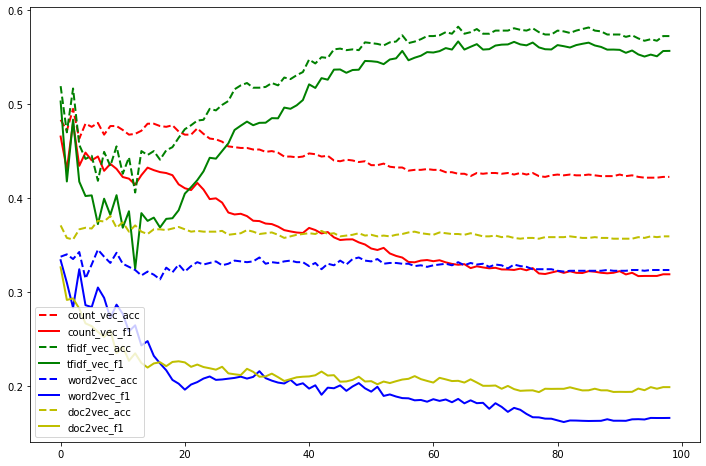

In [22]:
vec_accuracy = []
vec_f1s = []

for vec in vectorizers:
    X_train_dtm = vec.transform(X_train)
    X_test_dtm = vec.transform(X_test)

    accuracy = []
    f1s = []
    for i in range(1, 100):
        KNN = KNeighborsClassifier(n_neighbors = i)
        KNN.fit(X_train_dtm, y_train)
        y_pred = KNN.predict(X_test_dtm)
        
        accuracy.append(accuracy_score(y_test, y_pred))
        # Using average='weighted' to calculate a weighted average for the 3 classes 
        f1s.append(f1_score(y_test, y_pred, average='weighted'))

    vec_accuracy.append(accuracy)
    vec_f1s.append(f1s)

plot_line_graph_vector(vec_accuracy, vec_f1s, labels)

In [23]:
# Keep only vector with highest f1 score
f1_vects = [max(x) for x in vec_f1s]
max_f1 = f1_vects.index(max(f1_vects))

knn_accuracy = vec_accuracy[max_f1]
knn_f1s = vec_f1s[max_f1]

X_train_dtm = vectorizers[max_f1].transform(X_train)
X_test_dtm = vectorizers[max_f1].transform(X_test)

print("Best vectorizer for KNN:", labels[max_f1])

Best vectorizer for KNN: tfidf_vec


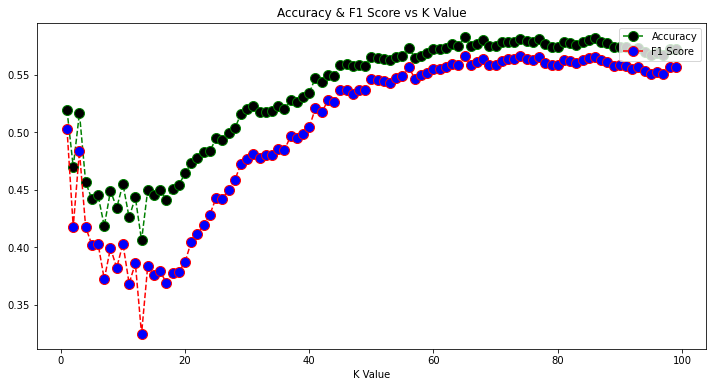

In [24]:
plot_metrics((1, 100), # tuple
             knn_accuracy,  # list
             knn_f1s, # list
             'K Value') # string eg. K Value, Maximum Depth

In [25]:
optimal_neighbors = knn_f1s.index(max(knn_f1s)) + 1
print("Optimal number of neighbors: ", optimal_neighbors)
print("Highest f1 score achieved: ", max(knn_f1s))

Optimal number of neighbors:  65
Highest f1 score achieved:  0.5667963367168672


##### Optimal K Value


In [26]:
%%time
# Accuracy using KNN model
KNN = KNeighborsClassifier(n_neighbors = optimal_neighbors)
KNN.fit(X_train_dtm, y_train)
y_pred = KNN.predict(X_test_dtm)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

Accuracy Score: 58.25%
F1 Score: 56.67963367168672%
Wall time: 278 ms


              precision    recall  f1-score   support

    NEGATIVE       0.69      0.47      0.56       386
     NEUTRAL       0.50      0.88      0.64       424
    POSITIVE       0.74      0.37      0.50       390

    accuracy                           0.58      1200
   macro avg       0.64      0.57      0.56      1200
weighted avg       0.64      0.58      0.57      1200



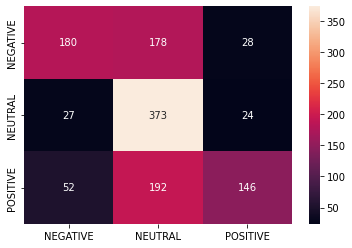

In [27]:
show_metrics(y_test, y_pred)

In [28]:
# Store results
logs['models']['knn'] = list(y_pred)
logs['metrics']['knn'] = {'accuracy': acc, 'f1 score': f1}

#### Logistic Regression

In [29]:
def opt_log(C):
    clf = LogisticRegression(solver = 'saga', multi_class = 'multinomial', C = C, random_state = SEED)
    clf.fit(X_train_log, y_train)
    y_pred = clf.predict(X_test_log)
    return f1_score(y_test, y_pred, average='weighted')

In [30]:
f1_ = []
opt_C = []

params = {
    'C' : (0.1, 100)
}

for vec in vectorizers:
    X_train_log = vec.transform(X_train)
    X_test_log = vec.transform(X_test)

    opt = BayesianOptimization(f = opt_log, pbounds = params, verbose = 0)

    opt.maximize(init_points = 10, n_iter = 10)

    f1_.append(opt.max['target'])
    opt_C.append(opt.max['params']['C'])

100%|█████████████████████████████████████████████████████████████████████████| 1200/1200 [00:00<00:00, 1202380.51it/s]


In [31]:
f1_

[0.6550195356543496,
 0.6779746774134693,
 0.3140143857771919,
 0.3247053867627327]

In [32]:
max_f1 = f1_.index(max(f1_))
opt_vectorizer = labels[max_f1]
optimal_C = max(opt_C)
print("The optimal vectorizer for logistic regression model: ", opt_vectorizer)
print("The max f1 score achieved: ", max(f1_))
print("The optimal C for logistic regression model: ", optimal_C)

The optimal vectorizer for logistic regression model:  tfidf_vec
The max f1 score achieved:  0.6779746774134693
The optimal C for logistic regression model:  20.40585805691716


##### Optimal C

In [33]:
%%time
# Accuracy using Logistic model
X_train_log = vectorizers[max_f1].transform(X_train)
X_test_log = vectorizers[max_f1].transform(X_test)

optimal_log = LogisticRegression(solver = 'saga', C = optimal_C, multi_class = 'multinomial', random_state = SEED)
optimal_log.fit(X_train_log, y_train)
y_pred = optimal_log.predict(X_test_log)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

# uncomment this if planning to run streamlit as this model will be loaded in the UI as a sample
# pickle.dump(optimal_log, open("/content/logistic_classifier.pkl", "wb"))

Accuracy Score: 63.66666666666667%
F1 Score: 63.64166107143583%
Wall time: 191 ms


              precision    recall  f1-score   support

    NEGATIVE       0.61      0.61      0.61       386
     NEUTRAL       0.65      0.68      0.67       424
    POSITIVE       0.64      0.61      0.63       390

    accuracy                           0.64      1200
   macro avg       0.64      0.64      0.64      1200
weighted avg       0.64      0.64      0.64      1200



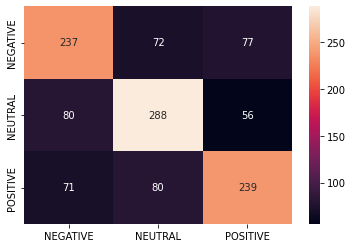

In [34]:
show_metrics(y_test, y_pred)

In [35]:
# Store results
logs['models']['logreg'] = list(y_pred)
logs['metrics']['logreg'] = {'accuracy': acc, 'f1 score': f1}

**NOTE: From this point onwards, we use TF-IDF vectorizer as it gives best accuracy.**

#### Naive Bayes Classifier

In [36]:
#Train using Multinomial Naaive Bayes model
model = MultinomialNB()
model.fit(X_train_dtm, y_train)

MultinomialNB()

In [37]:
#Model accuracy
model.score(X_test_dtm, y_test)
model_predictions = model.predict(X_test_dtm)
print(classification_report(y_test, model_predictions))

              precision    recall  f1-score   support

    NEGATIVE       0.65      0.67      0.66       386
     NEUTRAL       0.67      0.69      0.68       424
    POSITIVE       0.67      0.62      0.64       390

    accuracy                           0.66      1200
   macro avg       0.66      0.66      0.66      1200
weighted avg       0.66      0.66      0.66      1200



In [38]:
#Hyperparemeter tuning of alpha
param = {'alpha': [0.00001, 0.0001, 0.001, 0.1, 1]}

#using gridsearch
clf=GridSearchCV(model, param, cv=10, return_train_score=True)

#fit model for grid search
clf.fit(X_train_dtm, y_train)

GridSearchCV(cv=10, estimator=MultinomialNB(),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.1, 1]},
             return_train_score=True)

In [39]:
#print best alpha
print(clf.best_params_)

{'alpha': 1}


##### Optimal Alpha Value

In [40]:
%%time
#alpha value = 0.00001
y_pred = clf.predict(X_test_dtm)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

Accuracy Score: 66.16666666666666%
F1 Score: 66.13210255898305%
Wall time: 11 ms


              precision    recall  f1-score   support

    NEGATIVE       0.65      0.67      0.66       386
     NEUTRAL       0.67      0.69      0.68       424
    POSITIVE       0.67      0.62      0.64       390

    accuracy                           0.66      1200
   macro avg       0.66      0.66      0.66      1200
weighted avg       0.66      0.66      0.66      1200



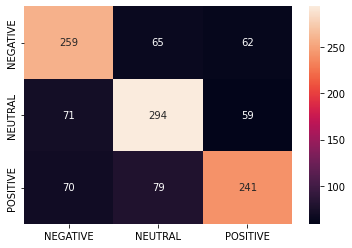

In [41]:
show_metrics(y_test, y_pred)

In [42]:
# Store results
logs['models']['nb'] = list(y_pred)
logs['metrics']['nb'] = {'accuracy': acc, 'f1 score': f1}

#### Support Vector Machine (SVM)

In [43]:
# Finding best hyperparameters for SVM model
svmParams = {'C': [0.1, 1, 10, 100], 'gamma': [1,0.1,0.01,0.001], 'kernel': ['rbf', 'sigmoid', 'linear', 'poly']}
svmBestParam = GridSearchCV(SVC(), svmParams, refit=True, verbose=1)
svmBestParam.fit(X_train_dtm, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'sigmoid', 'linear', 'poly']},
             verbose=1)

Best hyperparameters:  {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best score:  0.6644444444444444

Accuracy Score: 68.83333333333333%
F1 Score: 68.79892093488161%
              precision    recall  f1-score   support

    NEGATIVE       0.67      0.71      0.69       386
     NEUTRAL       0.70      0.71      0.70       424
    POSITIVE       0.71      0.64      0.67       390

    accuracy                           0.69      1200
   macro avg       0.69      0.69      0.69      1200
weighted avg       0.69      0.69      0.69      1200

Wall time: 472 ms


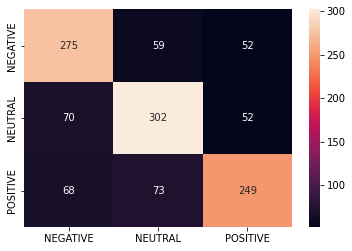

In [44]:
%%time
# Printing the best hyperparameters and score
print("Best hyperparameters: ", svmBestParam.best_params_) # print best hyperparams
print("Best score: ", svmBestParam.best_score_) # print best score
print("")

# Testing and showing metrics
svmPred = svmBestParam.predict(X_test_dtm)

acc = accuracy_score(y_test, svmPred) * 100
f1 = f1_score(y_test, svmPred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

show_metrics(y_test, svmPred)

In [45]:
# Store results
logs['models']['svm'] = list(svmPred)
logs['metrics']['svm'] = {'accuracy': acc, 'f1 score': f1}

#### Decision Trees


In [46]:
dt_accuracy = []
dt_f1s = []

for i in tqdm(range(1, 201)):
    dt = DecisionTreeClassifier(max_depth = i, random_state = SEED)
    dt.fit(X_train_dtm, y_train)
    y_pred = dt.predict(X_test_dtm)
    
    dt_accuracy.append(accuracy_score(y_test, y_pred))
    # Using average='weighted' to calculate a weighted average for the 3 classes 
    dt_f1s.append(f1_score(y_test, y_pred, average='weighted'))

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:40<00:00,  4.93it/s]


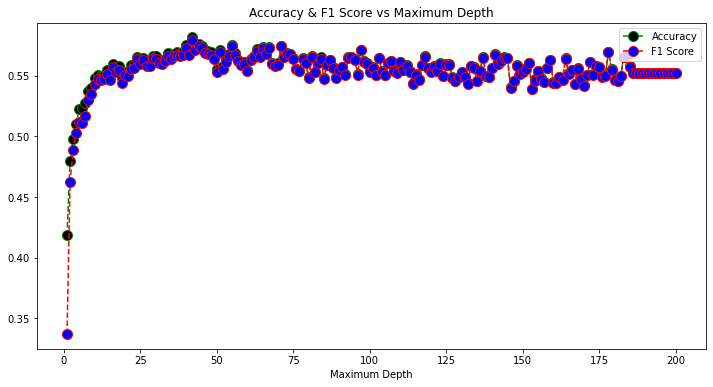

In [47]:
plot_metrics((1, 201), # tuple
             dt_accuracy,  # list
             dt_f1s, # list
             'Maximum Depth') # string eg. K Value, Maximum Depth

In [48]:
optimal_dt_depth = dt_f1s.index(max(dt_f1s)) + 1
print("Optimal maximum depth: ", optimal_dt_depth)
print("Highest f1 score achieved: ", max(dt_f1s))

Optimal maximum depth:  42
Highest f1 score achieved:  0.5797959515850906


##### Optimal Maximum Depth

In [49]:
%%time
# Accuracy using Decision Tree model
optimal_dt = DecisionTreeClassifier(max_depth = optimal_dt_depth, random_state = SEED)
optimal_dt.fit(X_train_dtm, y_train)
y_pred = optimal_dt.predict(X_test_dtm)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

Accuracy Score: 58.166666666666664%
F1 Score: 57.979595158509056%
Wall time: 169 ms


              precision    recall  f1-score   support

    NEGATIVE       0.58      0.58      0.58       386
     NEUTRAL       0.57      0.66      0.61       424
    POSITIVE       0.61      0.49      0.55       390

    accuracy                           0.58      1200
   macro avg       0.59      0.58      0.58      1200
weighted avg       0.58      0.58      0.58      1200



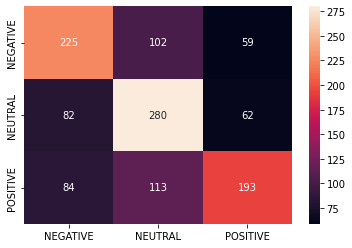

In [50]:
show_metrics(y_test, y_pred)

In [51]:
# Store results
logs['models']['dectree'] = list(y_pred)
logs['metrics']['dectree'] = {'accuracy': acc, 'f1 score': f1}

#### Extra Trees Classifier


In [52]:
et_accuracy = []
et_f1s = []

for i in tqdm(range(1, 101)):
    et_clf = ExtraTreesClassifier(max_depth = i, n_estimators = 250, random_state = SEED)
    et_clf.fit(X_train_dtm, y_train)
    y_pred = et_clf.predict(X_test_dtm)
    
    et_accuracy.append(accuracy_score(y_test, y_pred))
    # Using average='weighted' to calculate a weighted average for the 3 classes 
    et_f1s.append(f1_score(y_test, y_pred, average='weighted'))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:42<00:00,  2.22s/it]


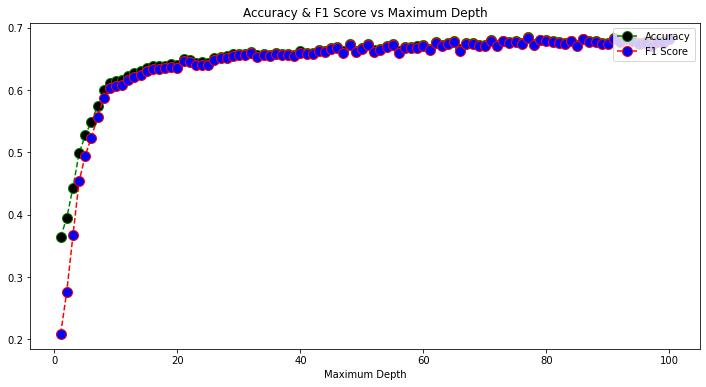

In [53]:
plot_metrics((1, 101), # tuple
             et_accuracy,  # list
             et_f1s, # list
             'Maximum Depth') # string eg. K Value, Maximum Depth

In [54]:
optimal_et_depth = et_f1s.index(max(et_f1s)) + 1
print("Optimal maximum depth: ", optimal_et_depth)
print("Highest f1 score achieved: ", max(et_f1s))

Optimal maximum depth:  77
Highest f1 score achieved:  0.6827405695312285


##### Optimal Maximum Depth

In [55]:
%%time
# Accuracy using ExtraTrees model
optimal_et = ExtraTreesClassifier(max_depth = optimal_et_depth, n_estimators = 250, random_state = SEED)
optimal_et.fit(X_train_dtm, y_train)
y_pred = optimal_et.predict(X_test_dtm)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

Accuracy Score: 68.41666666666667%
F1 Score: 68.27405695312285%
Wall time: 3.36 s


              precision    recall  f1-score   support

    NEGATIVE       0.73      0.65      0.69       386
     NEUTRAL       0.63      0.79      0.70       424
    POSITIVE       0.72      0.60      0.66       390

    accuracy                           0.68      1200
   macro avg       0.69      0.68      0.68      1200
weighted avg       0.69      0.68      0.68      1200



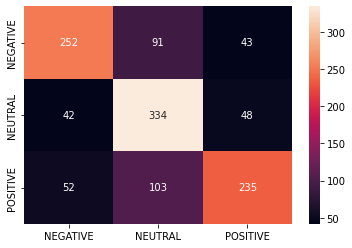

In [56]:
show_metrics(y_test, y_pred)

In [57]:
# Store results
logs['models']['extree'] = list(y_pred)
logs['metrics']['extree'] = {'accuracy': acc, 'f1 score': f1}

#### Random Forest

In [58]:
rand_forest_acc = list()
rand_forest_f1s = list()
for i in tqdm(range(10, 301, 10)):
    forest = RandomForestClassifier(n_estimators=i, oob_score=True, n_jobs=-1)
    forest.fit(X_train_dtm, y_train)
    y_pred_i = forest.predict(X_test_dtm)

    rand_forest_acc.append(accuracy_score(y_test, y_pred_i))
    rand_forest_f1s.append(f1_score(y_test, y_pred_i, average='weighted'))

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:27<00:00,  1.08it/s]


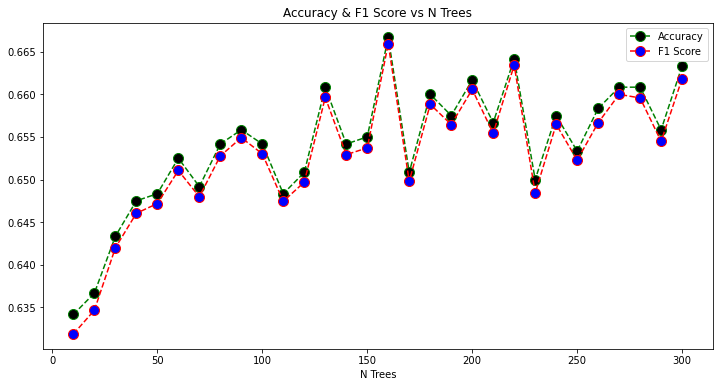

In [59]:
plot_metrics((10, 301, 10), # tuple
             rand_forest_acc,  # list
             rand_forest_f1s, # list
             'N Trees') # string eg. K Value, Maximum Depth

In [60]:
optimal_trees = rand_forest_f1s.index(max(rand_forest_f1s)) + 1
print("Optimal number of trees: ", optimal_neighbors)
print("Highest f1 score achieved: ", max(rand_forest_f1s))

Optimal number of trees:  65
Highest f1 score achieved:  0.6659166145594511


##### Optimal No. of Trees

In [61]:
%%time
forest = RandomForestClassifier(n_estimators=optimal_trees, oob_score=True, n_jobs=-1)
forest.fit(X_train_dtm, y_train)
y_pred = forest.predict(X_test_dtm)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

Accuracy Score: 63.24999999999999%
F1 Score: 63.185837940877946%
Wall time: 135 ms


              precision    recall  f1-score   support

    NEGATIVE       0.62      0.63      0.62       386
     NEUTRAL       0.61      0.69      0.65       424
    POSITIVE       0.68      0.57      0.62       390

    accuracy                           0.63      1200
   macro avg       0.64      0.63      0.63      1200
weighted avg       0.64      0.63      0.63      1200



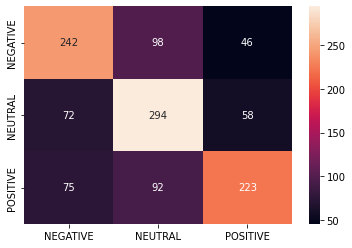

In [62]:
show_metrics(y_test, y_pred)

In [63]:
# Store results
logs['models']['randforest'] = list(y_pred)
logs['metrics']['randforest'] = {'accuracy': acc, 'f1 score': f1}

#### XGBoost


In [64]:
xgb_accuracy = []
xgb_f1s = []

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.fit_transform(y_test)

for i in tqdm(range(1, 31)):
    xgb = XGBClassifier(max_depth = i, n_estimators = 250)
    xgb.fit(X_train_dtm, y_train_encoded)
    y_pred_encoded = xgb.predict(X_test_dtm)
    y_pred = le.inverse_transform(y_pred_encoded)
    
    xgb_accuracy.append(accuracy_score(y_test, y_pred))
    # Using average='weighted' to calculate a weighted average for the 3 classes 
    xgb_f1s.append(f1_score(y_test, y_pred, average='weighted'))

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [13:16<00:00, 26.54s/it]


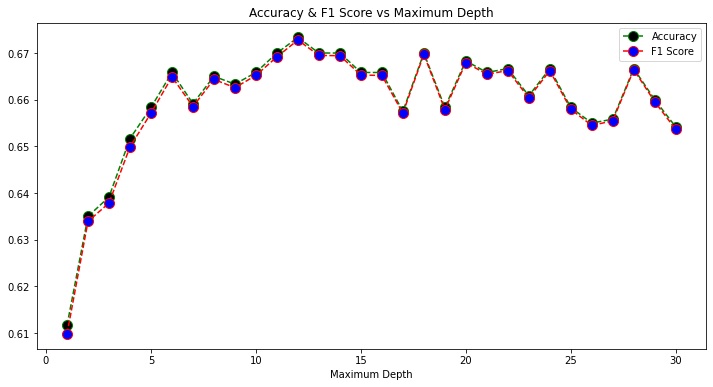

In [65]:
plot_metrics((1, 31), # tuple
             xgb_accuracy,  # list
             xgb_f1s, # list
             'Maximum Depth') # string eg. K Value, Maximum Depth

In [66]:
optimal_xgb_depth = xgb_f1s.index(max(xgb_f1s)) + 1
print("Optimal maximum depth: ", optimal_xgb_depth)
print("Highest f1 score achieved: ", max(xgb_f1s))

Optimal maximum depth:  12
Highest f1 score achieved:  0.6727821563199147


##### Optimal Maximum Depth

In [67]:
%%time
# Accuracy using XGBoost model
optimal_xgb = XGBClassifier(max_depth = optimal_xgb_depth, n_estimators = 250)
optimal_xgb.fit(X_train_dtm, y_train_encoded)
y_pred_encoded = optimal_xgb.predict(X_test_dtm)
y_pred = le.inverse_transform(y_pred_encoded)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

Accuracy Score: 67.33333333333333%
F1 Score: 67.27821563199147%
Wall time: 21.5 s


              precision    recall  f1-score   support

    NEGATIVE       0.65      0.67      0.66       386
     NEUTRAL       0.68      0.72      0.70       424
    POSITIVE       0.69      0.62      0.66       390

    accuracy                           0.67      1200
   macro avg       0.67      0.67      0.67      1200
weighted avg       0.67      0.67      0.67      1200



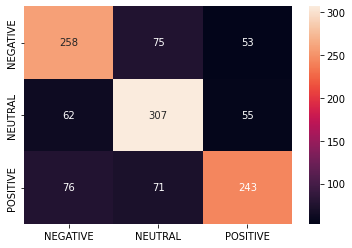

In [68]:
show_metrics(y_test, y_pred)

In [69]:
# Store results
logs['models']['xgboost'] = list(y_pred)
logs['metrics']['xgboost'] = {'accuracy': acc, 'f1 score': f1}

# Innovations

### Ensemble Classification




#### Import Packages

In [70]:
from sklearn.ensemble import StackingClassifier

#### Stacked Classifier

In [71]:
# Taking top 4 estimators base on f1 score
metrics_df = pd.DataFrame.from_dict(logs['metrics'])
metrics_df.sort_values(by=['f1 score'], axis=1, ascending=False, inplace=False)

,svm,extree,xgboost,nb,logreg,randforest,dectree,knn
accuracy,68.833333,68.416667,67.333333,66.166667,63.666667,63.250000,58.166667,58.250000
f1 score,68.798921,68.274057,67.278216,66.132103,63.641661,63.185838,57.979595,56.679634


In [72]:
stacked_estimators = [
                      ('xgb', XGBClassifier(max_depth = optimal_xgb_depth, n_estimators = 250, random_state = SEED)),
                      ('et', ExtraTreesClassifier(max_depth = optimal_et_depth, n_estimators = 250, random_state = SEED)),
                      ('svm', SVC(C = 1, gamma = 1, kernel = 'rbf')),
                      ('nb', MultinomialNB(alpha = 1))
                     ]

In [73]:
final_est = LogisticRegression(solver = 'saga', multi_class = 'multinomial', random_state = SEED)
stacked_clf = StackingClassifier(estimators = stacked_estimators,
                                final_estimator = final_est,
                                n_jobs = 1)

In [74]:
%%time
stacked_clf.fit(X_train_dtm, y_train_encoded)
y_pred_encoded = stacked_clf.predict(X_test_dtm)
y_pred = le.inverse_transform(y_pred_encoded)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

Accuracy Score: 69.83333333333334%
F1 Score: 69.77155239486137%
Wall time: 2min 22s


              precision    recall  f1-score   support

    NEGATIVE       0.68      0.73      0.70       386
     NEUTRAL       0.71      0.73      0.72       424
    POSITIVE       0.71      0.64      0.67       390

    accuracy                           0.70      1200
   macro avg       0.70      0.70      0.70      1200
weighted avg       0.70      0.70      0.70      1200



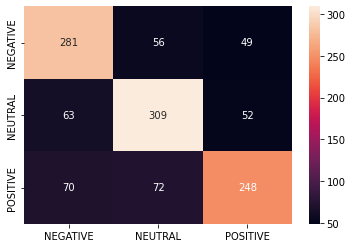

In [75]:
show_metrics(y_test, y_pred)

In [76]:
# Store results
logs['models']['stacked'] = list(y_pred)
logs['metrics']['stacked'] = {'accuracy': acc, 'f1 score': f1}

# Discussion

### Experiment Findings

In [77]:
# View test dataset with model results
findings_df = pd.DataFrame.from_dict(logs['models'])
findings_df = pd.merge(overall_df, findings_df, left_on='index', right_on='index')
findings_df.head()

,tweet,label_1,label_2,label_3,final_label,index,no_stopword_tweet,normalize_tweet,X_test,y_test,knn,logreg,nb,svm,dectree,extree,randforest,xgboost,stacked
0,iphone features appleevent you must buy it,POSITIVE,POSITIVE,POSITIVE,POSITIVE,9,iphone features appleevent must buy,iphone features appleevent must buy,iphone features appleevent must buy,POSITIVE,NEUTRAL,POSITIVE,POSITIVE,POSITIVE,POSITIVE,NEUTRAL,POSITIVE,POSITIVE,POSITIVE
1,hey this is real dope appleevent,POSITIVE,POSITIVE,POSITIVE,POSITIVE,12,hey real dope appleevent,hey real dope appleevent,hey real dope appleevent,POSITIVE,NEUTRAL,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE
2,thank you so much for this amazing opportunity,POSITIVE,POSITIVE,POSITIVE,POSITIVE,14,thank much amazing opportunity,thank much amazing opportunity,thank much amazing opportunity,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE
3,top best laptops for nursing school students,POSITIVE,POSITIVE,POSITIVE,POSITIVE,17,top best laptops nursing school students,top best laptops nursing school students,top best laptops nursing school students,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE
4,thoughtsol and apple together bring you the al...,POSITIVE,POSITIVE,POSITIVE,POSITIVE,18,thoughtsol apple together bring new apple watc...,thoughtsol apple together bring new apple watc...,thoughtsol apple together bring new apple watc...,POSITIVE,NEUTRAL,NEGATIVE,NEGATIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE


In [78]:
# Sort base on f1 score
metrics_df = pd.DataFrame.from_dict(logs['metrics'])
metrics_df.sort_values(by=['f1 score'], axis=1, ascending=False, inplace=False)

,stacked,svm,extree,xgboost,nb,logreg,randforest,dectree,knn
accuracy,69.833333,68.833333,68.416667,67.333333,66.166667,63.666667,63.250000,58.166667,58.250000
f1 score,69.771552,68.798921,68.274057,67.278216,66.132103,63.641661,63.185838,57.979595,56.679634


### Error Analysis

In [79]:
# Find differences between actual & predicted by our best classifier
error_df = findings_df.loc[~(findings_df['y_test'] == findings_df['stacked'])]

Text(0.5, 1.0, 'Number of Words Distribution in Error Dataset')

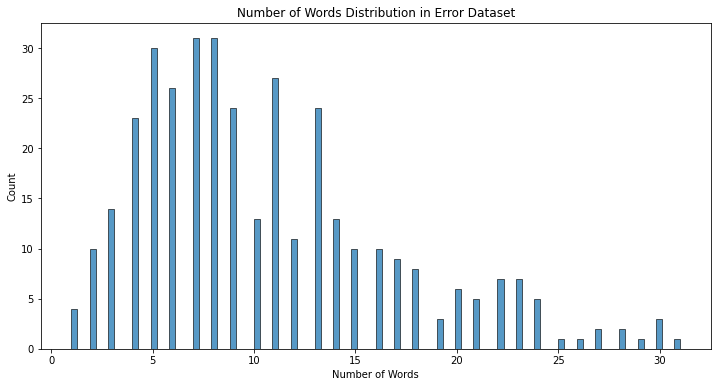

In [80]:
# Bar graph visualisation of word count distribution
plt.figure(figsize=(12,6))
sns.histplot([len(s.split(' ')) for s in error_df['X_test']], bins=100)
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.title("Number of Words Distribution in Error Dataset")

In [81]:
# Getting word
error_df['count'] = error_df['X_test'].apply(lambda x: len(x.split(' ')))
error_df['count'].value_counts()

8     31
7     31
5     30
11    27
6     26
9     24
13    24
4     23
3     14
10    13
14    13
12    11
16    10
15    10
2     10
17     9
18     8
22     7
23     7
20     6
21     5
24     5
1      4
19     3
30     3
28     2
27     2
25     1
31     1
26     1
29     1
Name: count, dtype: int64

In [82]:
# Eliminate errors for short normalized tweet length
error_df['short_tweet'] = error_df['X_test'].apply(lambda x: len(x.split(' ')) < 5)
error_df.loc[error_df['short_tweet'] == True][['tweet', 'X_test', 'y_test', 'stacked', 'short_tweet']]

,tweet,X_test,y_test,stacked,short_tweet
8,dominating the news this week here iphone,dominating news week iphone,POSITIVE,NEUTRAL,True
45,will there be any october appleevent for ipads,october appleevent ipads,POSITIVE,NEUTRAL,True
83,testing the apple world applewatchseries,testing apple world applewatchseries,POSITIVE,NEUTRAL,True
137,iphonepro get,iphonepro get,POSITIVE,NEUTRAL,True
139,guess who got the iphonepro in purple,guess got iphonepro purple,POSITIVE,NEUTRAL,True
146,its working iphonepromax,working iphonepromax,POSITIVE,NEGATIVE,True
156,purchase an iphonepromax i say,purchase iphonepromax say,POSITIVE,NEGATIVE,True
226,yeah,yeah,POSITIVE,NEGATIVE,True
228,just do it with iphone you dont need any dslr,iphone dont need dslr,POSITIVE,NEGATIVE,True
230,about to say fuck it and buy the iphone,say fuck buy iphone,POSITIVE,NEGATIVE,True


We notice that stopwords are sometimes necessary to define the sentiments of a tweet.